### Monitorización de la deriva

En este notebook se refleja el análisis del dataset de las predicciones

#### Importamos librerías necesarias

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Cargamos los datos de forecast y las observaciones que hemos usado para entrenamiento

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

df_observ = pd.read_parquet("../clean/df_definitivo.parquet")

# eliminamos repetidas, columnas que no participan en el modelo
df_observ.drop(columns=['Temperatura', 'wspd'], inplace=True) 

ct = ColumnTransformer([
    ('pass', 'passthrough', make_column_selector(dtype_include=object)),
    ('std_scaler', StandardScaler(), make_column_selector(dtype_include=np.number))
])

pd.DataFrame(ct.fit_transform(df_observ.drop(columns='AlturaOlas')), columns=ct.get_feature_names_out())
#df_forecast.drop_duplicates(['anio', 'mes', 'dia', 'hora'], inplace=True)

,std_scaler__anio,std_scaler__mes,std_scaler__dia,std_scaler__moonphase,std_scaler__hora,std_scaler__temp,std_scaler__dewPt,std_scaler__heat_index,std_scaler__rh,std_scaler__pressure,...,std_scaler__wdir_SSW,std_scaler__wdir_SW,std_scaler__wdir_VAR,std_scaler__wdir_W,std_scaler__wdir_WNW,std_scaler__wdir_WSW,std_scaler__Vviento,std_scaler__PeriodoOlas,std_scaler__Lluvia,std_scaler__Nubosidad
0,-1.326562,-1.488899,1.175737,-0.020054,0.606309,-0.701378,-0.679281,-0.700901,-0.083657,1.753365,...,-0.340373,2.095029,-0.303433,-0.343079,-0.237136,-0.42873,0.583398,-0.075623,-0.263243,-1.595046
1,-1.326562,-1.488899,1.175737,-0.020054,0.858144,-0.943285,-0.679281,-0.942484,0.326840,1.753365,...,-0.340373,2.095029,-0.303433,-0.343079,-0.237136,-0.42873,0.224965,-0.075623,-0.263243,-0.038476
2,-1.326562,-1.488899,1.175737,-0.020054,1.109978,-1.064238,-0.679281,-1.063275,0.819435,1.837057,...,-0.340373,2.095029,-0.303433,-0.343079,-0.237136,-0.42873,-0.133468,0.229585,-0.263243,0.739809
3,-1.326562,-1.488899,1.175737,-0.020054,1.361812,-1.064238,-0.804679,-1.063275,0.573138,1.837057,...,-0.340373,2.095029,-0.303433,-0.343079,-0.237136,-0.42873,-0.312684,0.229585,-0.263243,0.463643
4,-1.326562,-1.488899,1.175737,-0.020054,1.613647,-1.185191,-0.930078,-1.184067,0.573138,1.920748,...,-0.340373,2.095029,-0.303433,-0.343079,-0.237136,-0.42873,-0.312684,-0.075623,-0.263243,0.739809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12805,1.189653,1.562406,1.745813,0.568025,0.606309,-1.003761,-1.055476,-1.002880,-0.165756,-2.138282,...,-0.340373,-0.477320,-0.303433,-0.343079,4.216988,-0.42873,2.196345,0.534793,0.193873,0.739809
12806,1.189653,1.562406,1.745813,0.568025,0.858144,-1.003761,-1.055476,-1.002880,-0.165756,-2.054591,...,-0.340373,-0.477320,-0.303433,2.914777,-0.237136,-0.42873,2.196345,0.534793,-0.034685,0.739809
12807,1.189653,1.562406,1.745813,0.568025,1.109978,-1.185191,-1.306273,-1.184067,-0.165756,-1.887208,...,-0.340373,-0.477320,-0.303433,-0.343079,4.216988,-0.42873,1.658696,0.534793,-0.034685,0.739809
12808,1.189653,1.562406,1.745813,0.568025,1.361812,-1.064238,-1.431671,-1.063275,-0.576252,-1.761671,...,-0.340373,-0.477320,-0.303433,-0.343079,4.216988,-0.42873,1.658696,0.534793,-0.034685,0.739809


##### Diferencia en tamaño

In [18]:
df_observ.shape, df_forecast.shape

Index(['anio', 'mes', 'dia', 'moonphase', 'hora', 'temp', 'dewPt',
       'heat_index', 'rh', 'pressure', 'vis', 'wc', 'feels_like', 'uv_index',
       'wdir_E', 'wdir_ENE', 'wdir_ESE', 'wdir_N', 'wdir_NE', 'wdir_NNE',
       'wdir_NNW', 'wdir_NW', 'wdir_S', 'wdir_SE', 'wdir_SSE', 'wdir_SSW',
       'wdir_SW', 'wdir_VAR', 'wdir_W', 'wdir_WNW', 'wdir_WSW', 'Vviento',
       'AlturaOlas', 'PeriodoOlas', 'Lluvia', 'Nubosidad'],
      dtype='object')

Vemos que la diferencia entre los dos conjuntos es de más de 6 veces. 

Cogemos una muestra del mismo tamaño que los datos forecast para tener condiciones un poco más igualadas,

LA USAREMOS EN ALGUNOS APARTADOS


In [4]:
df_observ_mini = df_observ.sample(n=df_forecast.shape[0], random_state=777) # fijamos semilla
df_observ_mini.shape

(1834, 36)

## Distribución las variables explicativas más importantes
Nos fijaremos en las importancias de las variables del bosque

Cargamos el modelo que hemos seleccionado como el mejor

In [5]:
filename = '../modelos/modelo_definitivo/modelo_rf_def.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/tyomikjan/UNIVERSITY/PD1/PD/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Mostramos las importancias de las variables del modelo

Text(0.5, 1.0, 'Importancias de variables de modelo')

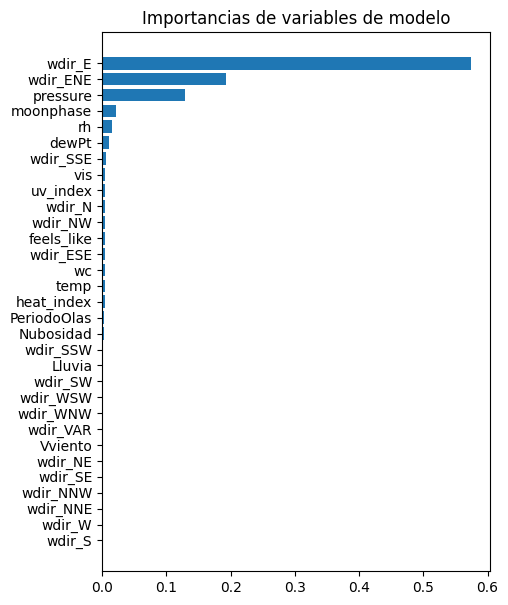

In [21]:
plt.figure(figsize=(5,7))
importancias = pd.DataFrame({'value': model.feature_importances_,'name': df_observ.drop(columns=['anio', 'mes', 'dia', 'hora', 'AlturaOlas']).columns})
importancias = importancias.sort_values(by='value')
plt.barh(y=importancias.name, width=importancias.value)
plt.title('Importancias de variables de modelo')

funcion auxiliar para ver los rangos de las variables

In [11]:
def range_eval(var):
    print(var)
    print('\t\t ', 'max', '  min')
    print('OBS\t\t ', df_observ[var].max(), '  ', df_observ[var].min())
    print('mini OBS ', df_observ_mini[var].max(), '  ', df_observ_mini[var].min())
    print('FORECAST ', df_forecast[var].max(), '  ', df_forecast[var].min())

### 1. VViento
(nudos)

In [12]:
var = 'Vviento'

Primero veremos el rango de la variable(max y min)

In [13]:
range_eval(var)

Vviento
		  max   min
OBS		  39    0
mini OBS  39    1
FORECAST  18    1


### 2. PeriodoOlas
(segundos)

In [14]:
var = 'PeriodoOlas'

Primero veremos el rango de la variable(max y min)

In [15]:
range_eval(var)

PeriodoOlas
		  max   min
OBS		  22    0
mini OBS  22    0
FORECAST  11    2


### 3. PRESION
(inHg, pulgadas de mercurio)

In [16]:
var = 'pressure'

Primero veremos el rango de la variable(max y min)

In [17]:
range_eval(var)

pressure
		  max   min
OBS		  30.79    28.32
mini OBS  30.76    28.655
FORECAST  30.36    29.66


## Distribución las alturas de las olas

Al tener predicciones del futuro (momentos posteriores a la fecha de elaboración de este código) nos quedaremos con las filas que tengan el valor real de la variable objetivo, AlturaOlas.

In [14]:
df_forecast_con_olas = df_forecast[~df_forecast.AlturaOlas.isna()]

Como tenemos datos de horas repetidas, las eliminamos para quedarnos con solo datos unicos(observaciones)

In [15]:
alturasObservaciones = df_forecast_con_olas.drop_duplicates(['anio', 'mes', 'dia', 'hora'])[['anio', 'mes', 'dia', 'hora', 'AlturaOlas']]

Vemos que hay relativamente muy pocas observaciones

In [16]:
alturasObservaciones.shape

(104, 5)

In [17]:
def class_ola(ola):
    if (ola < 1):
        return "x<1"
    if (ola < 2):
        return "1<x<2"
    if (ola < 3):
        return "2<x<3"
    else:
        return "x>3"

<Axes: title={'center': 'Segmentación de olas'}>

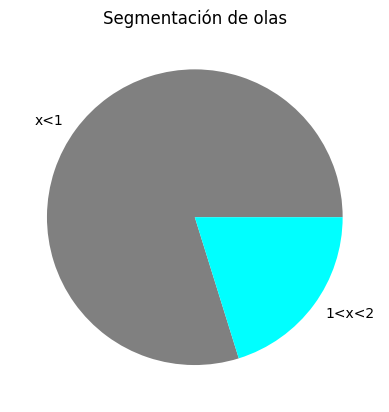

In [18]:
ola_clas = alturasObservaciones.AlturaOlas.map(class_ola)
ola_clas.value_counts().plot(kind='pie', label='', title='Segmentación de olas', colors=['gray', "aqua", "yellow", "red"])

En este caso las olas son de altura medianamente baja